In [1]:
import random

import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from tqdm import tqdm, trange
from torch.autograd import Variable
import sys
sys.path.append("../")

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
from youchoose.data.data_loading import ratings_dataloader
from youchoose.extraction.nn_latent_matrix_factorization import MatrixFactorization

In [54]:
# movie rating dataset
df = pd.read_csv("../data/ml-latest-small/ratings.csv")
print("Number of interactions in dataset: ",len(df), "\n")
df.head()

Number of interactions in dataset:  100836 



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Because we don't yet have the ability to handle sequences or time series in our recommendation, we will leave out the timestamp information for now.

In [20]:
unique_movies = {x for x in df.movieId}
print(f"Number of unique movies {len(unique_movies)}")
unique_users = {x for x in df.userId}
print(f"Number of unique users {len(unique_users)}")
print(f"The sparsity of the user-movie interaction matrix is {(100 * len(df) / (len(unique_movies) * len(unique_users))):.2f} %")

Number of unique movies 9724
Number of unique users 610
The sparsity of the user-movie interaction matrix is 1.70 %


In [22]:
# for the recommendation engine, we need user_id, item_id, and interactions
df = df[["userId", "movieId", "rating"]]
df.columns = ["user_id", "item_id", "interactions"]
df.head()

,user_id,item_id,interactions
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


So far we have only worked with implicit recommendations and so we need to convert the ratings/interactions to values 0/1. One way to do that is just setting everything a user rated as a interaction and try and predict if a user is likely to watch a movie, but give no indication about if they will like it or not.

In [42]:
df_grouped = df[["item_id", "interactions"]].groupby(["item_id"]).count()
df_grouped.reset_index(inplace=True)
most_watched = df_grouped.sort_values(by='interactions', ascending=False)
df_grouped = df[["item_id", "interactions"]].groupby(["item_id"]).mean()
df_grouped.reset_index(inplace=True)
highest_rated = df_grouped.sort_values(by='interactions', ascending=False)
print(
    f"5 Most Watched Movies:\n{most_watched.head(5)}\n\n"
    f"5 Highest Rated Movies:\n{highest_rated.head(5)}"
)

5 Most Watched Movies:
      item_id  interactions
314       356           329
277       318           317
257       296           307
510       593           279
1938     2571           278

5 Highest Rated Movies:
      item_id  interactions
7638    88448           5.0
8089   100556           5.0
9065   143031           5.0
9076   143511           5.0
9078   143559           5.0


OK, so it would be nice if we knew what movies these IDs are associated with.

In [34]:
df_movies = pd.read_csv("../data/ml-latest-small/movies.csv")
df_movies = df_movies.iloc[:,0:2]
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [38]:
# Now we convert the movie_id and title into a dictionary mapping ids to titles.
movie_dict = dict(zip(df_movies.movieId, df_movies.title))

In [45]:
most_watched["title"] = most_watched.item_id.map(movie_dict)
most_watched.head(10)

,item_id,interactions,title
314,356,329,Forrest Gump (1994)
277,318,317,"Shawshank Redemption, The (1994)"
257,296,307,Pulp Fiction (1994)
510,593,279,"Silence of the Lambs, The (1991)"
1938,2571,278,"Matrix, The (1999)"
224,260,251,Star Wars: Episode IV - A New Hope (1977)
418,480,238,Jurassic Park (1993)
97,110,237,Braveheart (1995)
507,589,224,Terminator 2: Judgment Day (1991)
461,527,220,Schindler's List (1993)


In [46]:
highest_rated["title"] = highest_rated.item_id.map(movie_dict)
highest_rated.head(10)

,item_id,interactions,title
7638,88448,5.0,Paper Birds (Pájaros de papel) (2010)
8089,100556,5.0,"Act of Killing, The (2012)"
9065,143031,5.0,Jump In! (2007)
9076,143511,5.0,Human (2015)
9078,143559,5.0,L.A. Slasher (2015)
4245,6201,5.0,Lady Jane (1986)
8136,102217,5.0,Bill Hicks: Revelations (1993)
8130,102084,5.0,Justice League: Doom (2012)
4240,6192,5.0,Open Hearts (Elsker dig for evigt) (2002)
9104,145994,5.0,Formula of Love (1984)


## Collaborative Filtering

For the models we will want to use a numeric index rather than the product_id and user_id so that we can easily match the embedding vector with the user or product.

In [50]:
epochs = 35
print_every = 1
embedding_dim = 10
l2 = 0
lr = 0.1
loss_fn = nn.MSELoss
dataframe = df.sample(1000, random_state=23)  # here we are only taking 500 interactions
dataframe.columns = ["user_id", "item_id", "interaction"]

num_negs = 0
bs = 100

(tr_load, va_load, te_load), n_users, n_prod = ratings_dataloader(
    dataframe, batch_size=bs, dev=dev, num_negs=num_negs,
)

model = MatrixFactorization(
        n_users, n_prod, n_factors=embedding_dim, lr=lr, l2=l2, loss_fn=loss_fn
    ).to(dev)

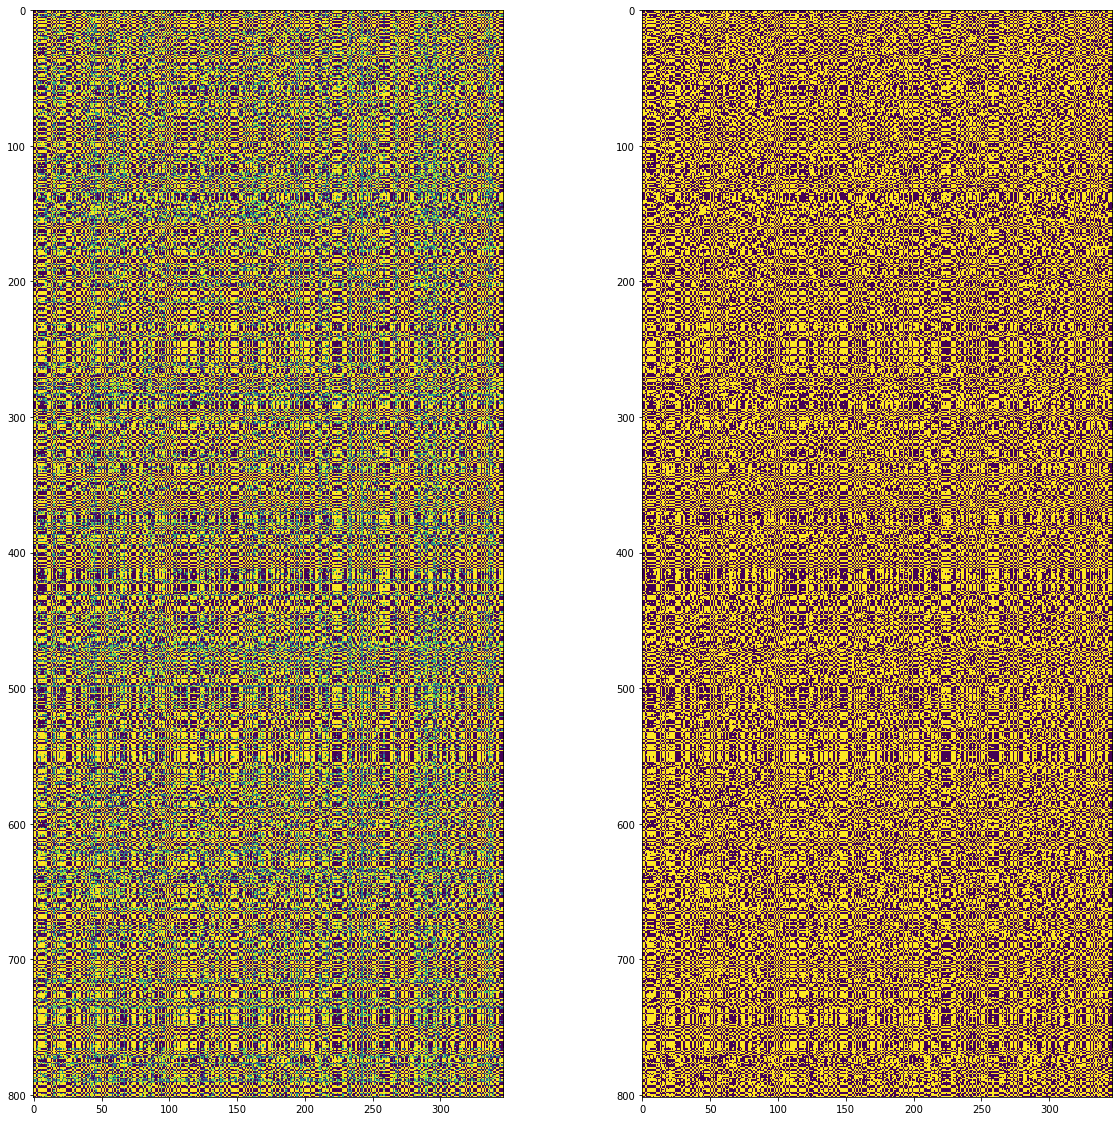

In [51]:
# before training user-item interaction matrix
user_em = model.user_factors.weight.detach()
item_em = model.product_factors.weight.detach()
user_b = model.user_bias.weight.detach()
item_b = model.product_bias.weight.detach()

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,20))
ax1.imshow(model.activation((item_em + item_b) @ (user_em + user_b).transpose(0,1)).numpy())
ax2.imshow(model._prob_to_class((item_em + item_b) @ (user_em + user_b).transpose(0,1)).numpy())
plt.show()

In [52]:
for epoch in range(epochs):
    train_loss, train_accuracy = model.train_model(tr_load)
    val_loss, val_accuracy = model.evaluate(va_load)

    if (epoch + 1) % print_every == 0:
        print(
            f"epoch #{epoch + 1}, "
            f"training loss: {train_loss:0.3f}, "
            f"training accuracy: {train_accuracy}, "
            f"validation loss: {val_loss:0.3f}, "
            f"validation accuracy: {val_accuracy}, "
        )

epoch #1, training loss: 100.465, training accuracy: 54.12, validation loss: 12.064, validation accuracy: 49.00, 
epoch #2, training loss: 89.220, training accuracy: 54.38, validation loss: 11.872, validation accuracy: 48.00, 
epoch #3, training loss: 79.566, training accuracy: 55.00, validation loss: 11.701, validation accuracy: 48.00, 
epoch #4, training loss: 71.238, training accuracy: 56.00, validation loss: 11.550, validation accuracy: 48.00, 
epoch #5, training loss: 64.017, training accuracy: 57.12, validation loss: 11.414, validation accuracy: 48.00, 
epoch #6, training loss: 57.697, training accuracy: 57.88, validation loss: 11.293, validation accuracy: 50.00, 


KeyboardInterrupt: 

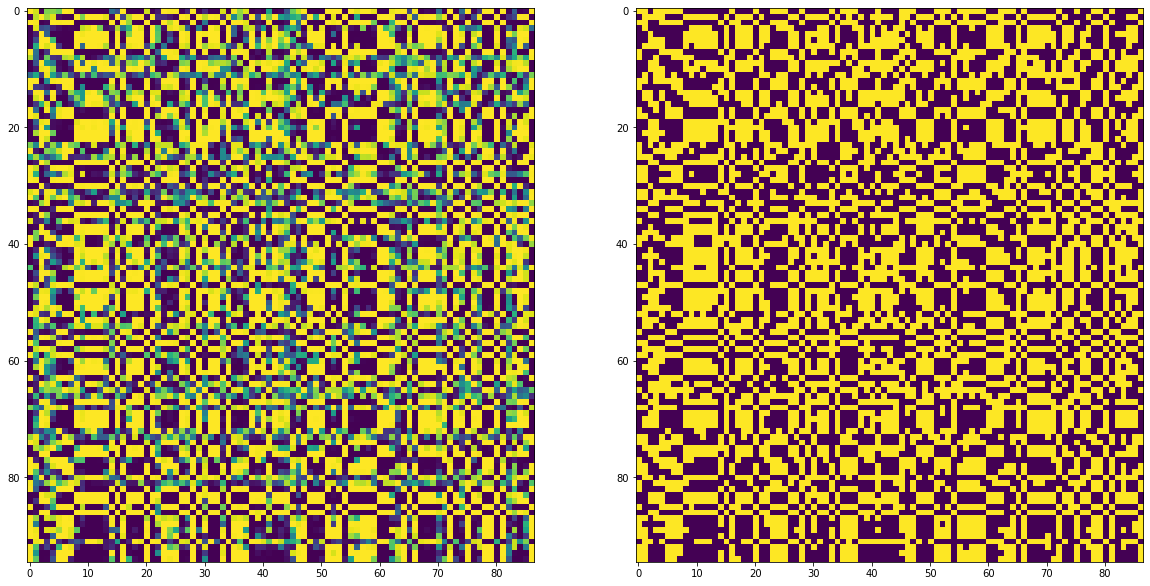

In [50]:
user_em = model.user_factors.weight.detach()
item_em = model.product_factors.weight.detach()
user_b = model.user_bias.weight.detach()
item_b = model.product_bias.weight.detach()

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,20))
ax1.imshow(model.activation((item_em + item_b) @ (user_em + user_b).transpose(0,1)).numpy())
ax2.imshow(model._prob_to_class((item_em + item_b) @ (user_em + user_b).transpose(0,1)).numpy())
plt.show()

In [33]:
model.activation

Sigmoid()

In [40]:
model._prob_to_class(item_em @ user_em.transpose(0,1)).numpy()

array([[0., 1., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)

In [ ]:
sigmoid = nn.Sigmoid()
users_items = sigmoid(
    model.user_factors.weight @ model.product_factors.weight.transpose(0, 1)
)
values = users_items.detach().numpy()

plt.hist(values.ravel(), bins=50)
plt.show()

In [ ]:
def recommend_item_for_user(model, user_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in [user_id] * len(items)])
    item_ids = torch.LongTensor([item2idx[b] for b in items])

    remove = set(ratings[ratings[user_col] == user_id][item_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_item = [
        (p, b) for p, b in sorted(zip(preds, items), reverse=True) if b not in remove
    ]

    return pred_item


def recommend_user_for_item(model, item_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in users])
    book_ids = torch.LongTensor([item2idx[b] for b in [item_id] * len(users)])

    remove = set(ratings[ratings[item_col] == book_id][user_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_user = [
        (p, u) for p, u in sorted(zip(preds, users), reverse=True) if u not in remove
    ]

    return pred_user